# Using NIST WEBBOK data
Thermodynamics:

In [1]:
TAME_h = -341.8 # [kJ/mol]
MeOH_h = -238.4 # [kJ/mol] 
MeOH_Cp = 81 # [J/mol/K]
MeOH_d  = 0.792*1000 # [g/L]
MeOH_M = 32.04 # [g/mol]
_2M1B_h = -61 # [kJ/mol]
_2M1B_Cp = 157 # [kJ/mol]
_2M2B_h = -68 # [kJ/mol]
_2M2B_Cp = 152 # [kJ/mol]

Reaction kinetics:

In [2]:
Q = 5.2 # [cm3/min] - flow rate
L = 259 # [mm] - bed length
V = L*(3.14*(16/2)**2)/1000 # [cm3] - reactor volume
Rm_ia = 1.5 # Ratio MeOH/2M1B
C = 1 # [mol/L]
meohL = 1/MeOH_d*MeOH_M # [L/mol]
C_m = 1/meohL # [mol/L]
X = 0.5 # conversion
rt = V/Q # res. time, [min]

In [3]:
V2 = 100*(3.14*(4.12/2)**2)/1000 # vol of my reactor [cm3]
V2/rt # required Q for same rt [cm3/min]

0.1331245173745174

Maximum temp rise:
$$
\Delta T = \frac{\Delta H}{C_p}
$$

In [4]:
dT_mol = ((MeOH_h + _2M1B_h) - TAME_h)*1000/_2M1B_Cp

In [5]:
print(f'dT at R={Rm_ia}: {dT_mol/Rm_ia:0.1f}, K')

dT at R=1.5: 180.0, K


calculate for high dilution. 
Kinetics - no activities, no mass transfer limitations

In [11]:
dT_C = dT_mol*C*meohL
print(f'dT per 2M1B concentration C={C}[mol/L]: {dT_C:0.1f}, K')

dT per 2M1B concentration C=1[mol/L]: 10.9, K


Kinetic model
---------------

Constants:

In [62]:
R = 8.314e-3 # [kJ/K/mol]
k1 = 2.52e15 # [mol/g/h]
k2 = 9.5e12 # [mol/g/h]
k3 = 5.42e11 # [mol/g/h]
E1 = 106.47 # [kJ/mol]
E2 = 92.45 # [kJ/mol]
E3 = 82.43 # [kJ/mol]
dH_ads = -17 # [kj/mol]
Km = 8.34e-2 # [-]

Variables

In [63]:
T = 293

Equations

In [124]:
def k(A,Ea,T):
    return A*np.exp(-Ea/R/T)

def Keq1(T):
    return np.exp(4.63e3/T - 9.875)

def Keq2(T):
    return np.exp(3.57e3/T - 9.382)

def r1(T,k1,Km,Cm,C1b,Ct):
    k1 = k(k1,E1,T)
    return (k1*Km**2)/(1+Km*Cm)**2 * (Cm*C1b-Ct/Keq1(T))

def r2(T,k2,Km,Cm,C2b,Ct):
    k2 = k(k2,E2,T)
    return (k2*Km**2)/(1+Km*Cm)**2 * (Cm*C2b-Ct/Keq2(T))

def r3(T,k3,Km,Cm,C1b,C2b):
    k3 = k(k3,E3,T)
    Keq3 = Keq1(T)/Keq2(T)
    return (k3*Km**2)/(1+Km*Cm) * (C1b-C2b/Keq3)

Model

In [88]:
import numpy as np
import chemreact
import copy

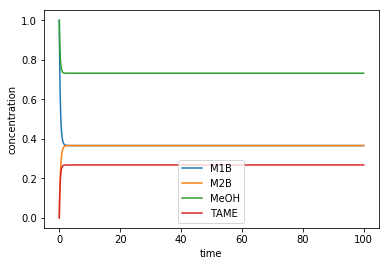

run time: 0.016s


In [89]:
c = chemreact.models.Chemistry()
c.reaction('M1B+MeOH<=>TAME')
c.reaction('M2B+MeOH<=>TAME')
c.reaction('M1B<=>M2B')
c.initial_concentrations(M1B=1, MeOH=1)
c.run()

In [90]:
c2 = copy.deepcopy(c)

In [91]:
c2.variables

OrderedDict([('M1B', 0), ('M2B', 0), ('MeOH', 0), ('TAME', 0)])

In [125]:
def _ode(t, y):
    m1b = y[0]
    m2b = y[1]
    meoh = y[2]
    tame = y[3]
    _r1 = r1(T,k1,Km,meoh,m1b,tame)
    _r2 = r2(T,k2,Km,meoh,m2b,tame)
    _r3 = r3(T,k3,Km,meoh,m1b,m2b)
    
    d_m1b = -_r1 - _r3
    d_m2b = -_r2 + _r3
    d_meoh = - _r1 - _r2
    d_tame = _r1 + _r2
    return [d_m1b, d_m2b, d_meoh, d_tame]

In [126]:
c2._ode = _ode

In [127]:
c2.time_stop = 2000

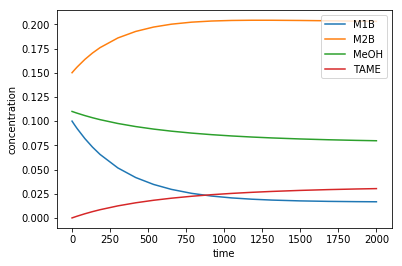

run time: 0.010s


In [128]:
T=353
c2.initial_concentrations(M1B = 0.1, M2B= 0.15, MeOH = 0.11)
c2.run()

In [121]:
%pip list

Package            Version
------------------ -------
attrs              19.1.0 
backcall           0.1.0  
bleach             3.1.0  
chemreact          0.0.1  
colorama           0.4.1  
cycler             0.10.0 
decorator          4.4.0  
defusedxml         0.6.0  
entrypoints        0.3    
findiff            0.6.3  
ipykernel          5.1.0  
ipython            7.5.0  
ipython-genutils   0.2.0  
ipywidgets         7.4.2  
jedi               0.13.3 
Jinja2             2.10.1 
jsonschema         3.0.1  
jupyter-client     5.2.4  
jupyter-core       4.4.0  
kiwisolver         1.1.0  
MarkupSafe         1.1.1  
matplotlib         3.0.3  
mistune            0.8.4  
nbconvert          5.5.0  
nbformat           4.4.0  
notebook           5.7.8  
numpy              1.16.3 
pandocfilters      1.4.2  
parso              0.4.0  
pickleshare        0.7.5  
pip                18.1   
prometheus-client  0.6.0  
prompt-toolkit     2.0.9  
Pygments           2.4.0  
pyparsing          2.4.0  
p

You are using pip version 18.1, however version 19.2.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.
